# Data Analysis Template for PAX Data
___

Authored by: [Nathan Belmore](https://plasma.physics.berkeley.edu/faculty-staff/nathan-belmore) 

Published: 9.1.2019

Current working version: V0.3.1

Change Log:
* 0.3.1: Added variable to extend the integration window manually. 
* 0.3: Turned process into functions to make it easier to apply to several data sets in the same notebook.
* 0.2: Added support for backgrounds and per-dataset operations 
* 0.1: Initial counting.

To do: 
* Add double count support. (With the current data sets it rare so I've been focusing on other things)
* Update to read_csv


# Analysis
***



In [1]:
# creating the correct enviroment for analysis
import os
import re
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import argrelextrema, savgol_filter
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import BreitWignerModel

# Setting parameters to make plots clear for publication
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

# Importing the data

In [2]:
def ImportData(path, FullOutput=False):
    """ImportData(path, FullOutput=False)
    Designed to import the data from a local directory.
    Inputs:
        Path: Path to folder containing the data.
        FullOutput: Prints each file imported. 
    
    Returns:
        index: data frame with the attributes for the data frames
        data: pd.seires of dp.dataframes, each dataframe is a set of data.
    """
    # some data structure for genetrating a list of the files. 
    files = []
    
    for file in os.listdir(path):
        if file.endswith(".txt") and not file.startswith("Scope_bin"):
            files.append(file)
    files.sort()
    if FullOutput:
        print('Files imported:')
    
    # Importing the data in a pandas dataframe
    
    dfs = []
    names=['time', 'ch1', 'ch2', 'ch3', 'ch4']
    index = []
    
    for num, fname in enumerate(files, start=1):
        if FullOutput:
            print("File #{} | {}".format(num - 1, fname))
        if len(fname) > 0:
            pathname = os.path.join(path, fname)
            data = pd.read_table(pathname, index_col='time', sep='\t', names=names)
            dfs.append(data)
            index.append([int(s) for s in re.findall(r'\d+', fname)][-3:])
    print('File import complete.')
    index = pd.DataFrame(index, columns=['eV', 'delay', 'iter'])
    data = pd.Series(dfs)
    return data, index

## Selecting the data range

Below we will automate some of the data selection

In [3]:
def ProcessData(data, 
                index, 
                plottitle='Full Data Set', 
                PeakPerDataSet=False, 
                BackgroundSubtract=True, 
                DisplayFullOutput=False,
                ExtendIntRange=[0, 0]):
    """ProcessData(data, 
        index, 
        plottitle='Full Data Set', 
        PeakPerDataSet=False, 
        BackgroundSubtract=True, 
        DisplayFullOutput=False)
        
    Fill in a few more details here about the process once finished developing
    the function.
    
    Inputs:
        data: pd.series of pd.dataframes, each data frame is a dataset. 
            Designed to work with the output of ImportData()
        index: data frame with the attributes for the data frames
            Designed to work with the output of ImportData()
        
        plottitle: The names used in the plots
            (default='Full Data Set')
        PeakPerDataSet: Instead of looking for an integration window from
            the entire data set, it looks at the different hold times and
            generates peaks on a per hold time basis.
            (default=False)
        BackgroundSubtract: Uses the area outside of the integration window
            to calculate and subtract a background from the data sets.
            (default=True)
        DisplayFullOutput: In the case PeakPerDataSet is true, it will display
            the binned results for every delay.
            (default=False)
        ExtendIntRange: Extends the selected intergation range by [L, R],
            where L adds L bins to the left, and R adds R bins to the right.
    """

	####### Setting up the data structures we need ####### 
    
    delays = index['delay'].unique()
    
    # counts (ARRAY of arrays), each array will contain the times for 
    # the peak region from the histogram. 
    counts = [[] for i in range(len(delays))]
    
    # ncounts (ARRAY of arrays), each array will contain the counts for 
    # the peak region from the histogram. 
    ncounts = [[] for i in range(len(delays))]
    
    # CountsPerDelay (Array), each value is the sum of counts for a given delay
    if PeakPerDataSet:
        CountsPerDelay = np.zeros(len(delays)) 
    
        
    ####### Binning the data, finding the integration region, and background subtraction ####### 
    
    for i, delay in enumerate(index['delay'].unique()):
        for setindex in index[index['delay'] == delay].index:
            y = data[setindex]['ch3']
            peaks, properties = find_peaks(y, prominence=0.05, width=60, distance=30)
            counts[i] = np.concatenate((counts[i], data[setindex].iloc[peaks].index), axis=None)
        
        
        # Calculating the counts for each data set.
        if DisplayFullOutput == True:
            fig, ax = plt.subplots(figsize=(13, 7))
            ax.set_title(f'Delay: {delay}')
            ax.grid(True)
            ncounts[i], bins, _ = plt.hist(counts[i], 
                                           bins=15, 
                                           label='Binned Counts',
                                           range=(data[setindex].index.min(), 
                                                                      data[setindex].index.max()))
        else:
            ncounts[i], bins = np.histogram(counts[i], bins=15, range=(data[setindex].index.min(), 
                                                                       data[setindex].index.max()))
    
        # Finding the peaks on a per data set basis
        if PeakPerDataSet == True:
            # Setting the left and right limits of the peak region
            delta = bins[1] - bins[0]
            x = [bins[i+1] - delta/2 for i in range(len(bins) - 1)]
    
            # Finding the peak and the region around the peak
            peaks, properties = find_peaks(ncounts[i], prominence=5)
        
            # Setting the left and right limits of the peak region
            xmin = peaks[0] - 1 - ExtendIntRange[0]
            xmax = properties['right_bases'][0] + ExtendIntRange[1]
            
            # Plotting results if Diaplay Full Output is on
            if DisplayFullOutput == True:
                ax.axvspan(bins[xmin], bins[xmax], color='green', alpha=0.1, 
                   label="Selected Integration Window")
                
            # Calculate the background count per bin and subtract it from the bins.
            if BackgroundSubtract:
                # Integrate the area outside of the intergration window and divide by number of bins.
                background = np.sum(np.concatenate(
                    (ncounts[i][:xmin], ncounts[i][xmax + 1:]), axis=None)) / (len(ncounts[i][:xmin]) + len(ncounts[i][xmax + 1:]))
                
                # Summing up counts over the integration window with background subtraction.
                CountsPerDelay[i] = np.sum(ncounts[i][xmin:xmax]) - np.round((xmax-xmin) * background)
                
                # Display the avegrage background level on the plot
                if DisplayFullOutput == True:
                    ax.axhline(y=background, color='r', linestyle='--', label="Calculated Background Count")
            
            # Summing up counts over the integration window without background subtraction.
            if not BackgroundSubtract:
                CountsPerDelay[i] = np.sum(ncounts[i][xmin:xmax])
        # Plotting the region selected for integration
#         ax.legend()
        plt.show()
        
    
    
    ####### Examing the total data set ####### 
    # Insead of looking at each set of delays independently we can can examine the 
    # data set as a whole. This will help provide better statistics for background
    # calculations. If it's expected that data will be coming out in the same time
    # window this option is ideal.
    
    if not PeakPerDataSet:
        # Calculating the total counts from all values
        totalcount = np.concatenate(counts, axis=None)
        fig, ax = plt.subplots(figsize=(13, 7))
        
        # Creating a histogram of the total data set
        n, bins, patches = plt.hist(totalcount, 
                                    bins=15, 
                                    range=(data[0].index.min(), data[0].index.max()), 
                                    label="Binned Counts") 
        ax.set_title(str(plottitle) + ': Total Data Set Binned')
        ax.grid(True)
        
        # Generating the midpoint for each bin
        delta = bins[1] - bins[0]
        x = [bins[i+1] - delta/2 for i in range(len(bins) - 1)]
        
        ####### Plotting the total data set with peaks ####### 
    
        # Finding the peak and the region around the peak
        peaks, properties = find_peaks(n, prominence=10)
    
        # Setting the left and right limits of the peak region
        xmin = peaks[0] - 1 - ExtendIntRange[0]
        xmax = properties['right_bases'][0] + ExtendIntRange[1]
        
        # Calculate the background count per bin for total data set
        # Subtract the background count from the data
        if BackgroundSubtract:
            # Integrate the area outside of the intergration window, divide by number of bins, round.
            background = np.sum(np.concatenate(
                (n[:xmin], n[xmax + 1:]), axis=None)) / (len(n[:xmin]) + len(n[xmax + 1:]))
            
            # Summing up counts over the integration window with background subtraction.
            # There is an extra factor to account for the porportion of the data to the whole data set.
            CountsPerDelay = [np.sum(ncounts[i][xmin:xmax]) - np.round((xmax-xmin) * 
                                                                       background * 
                                                                       np.sum(index['delay'] == delays[i]) / 
                                                                       len(index)) for i in range(len(ncounts))]
            
            # Display the avegrage background level on the plot
            ax.axhline(y=background, color='r', linestyle='--', label="Calculated Background Count")
        
        # Summing up counts over the integration window without background subtraction.
        if not BackgroundSubtract:
            CountsPerDelay = [np.sum(ncounts[i][xmin:xmax]) for i in range(len(ncounts))]
            
        
        # Plotting the region selected for integration
        ax.axvspan(bins[xmin], bins[xmax], color='green', alpha=0.1, 
                   label="Selected Integration Window")
        ax.legend()
        plt.show()
    
        
    # Plot the final Count vs. Delay plot
    fig, ax = plt.subplots(figsize=(13, 7))
    ax.plot(index['delay'].unique(), CountsPerDelay, 'o', label='First')
    ax.set_xlabel('Delay (ms)')
    ax.set_ylabel('Count')
    ax.set_title(str(plottitle) + ': Full Data Set') 
    ax.legend()
    ax.grid(True)
    
    plt.show()
    
    return index['delay'].unique(), CountsPerDelay

In [4]:
path = 'overnightscan29.09'
data, index = ImportData(path)

/home/natephysics/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: read_table is deprecated, use read_csv instead.


File import complete.


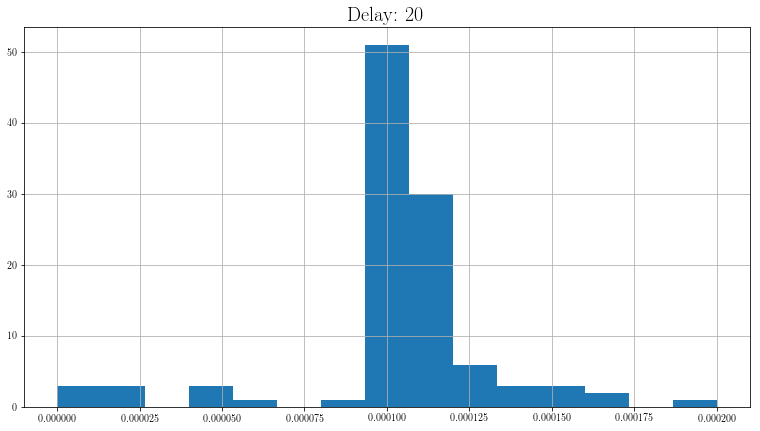

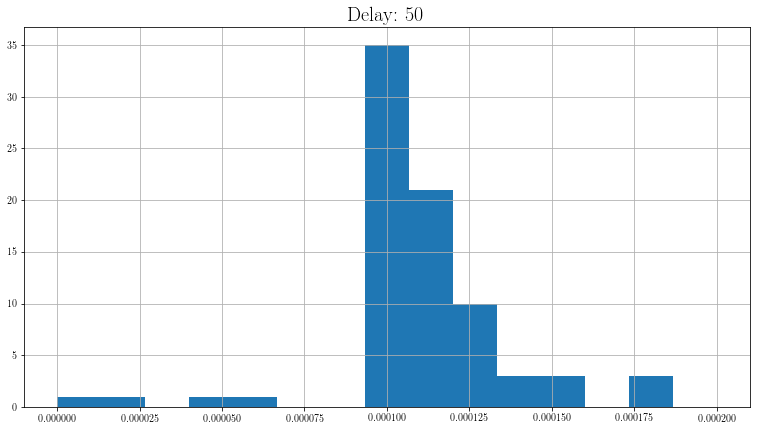

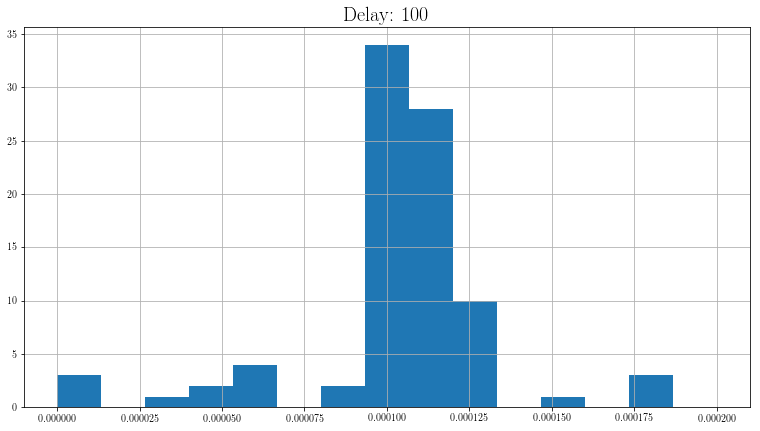

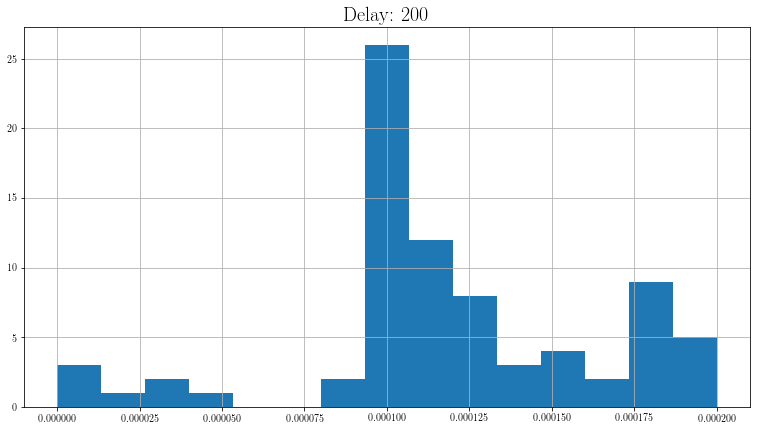

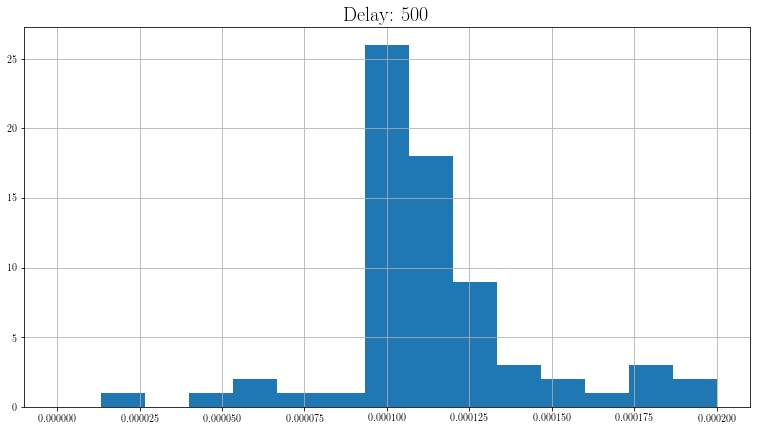

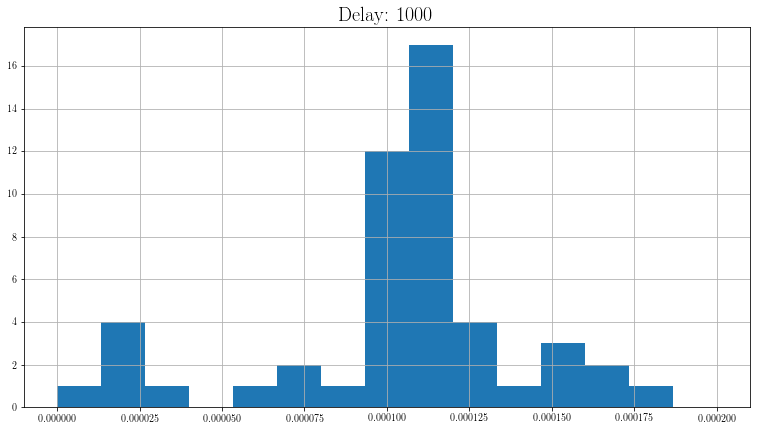

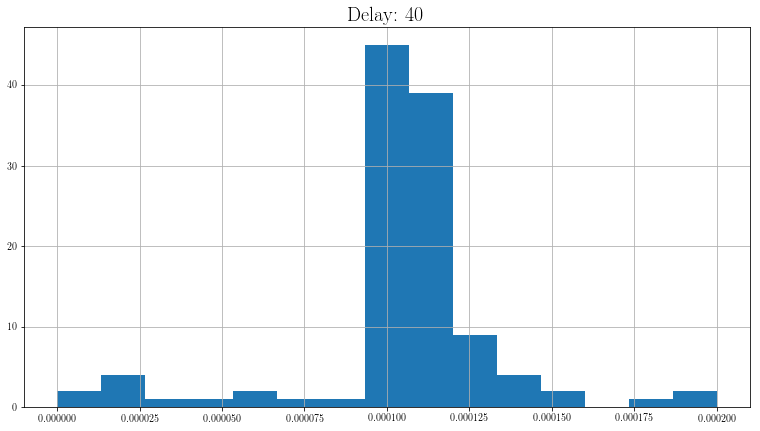

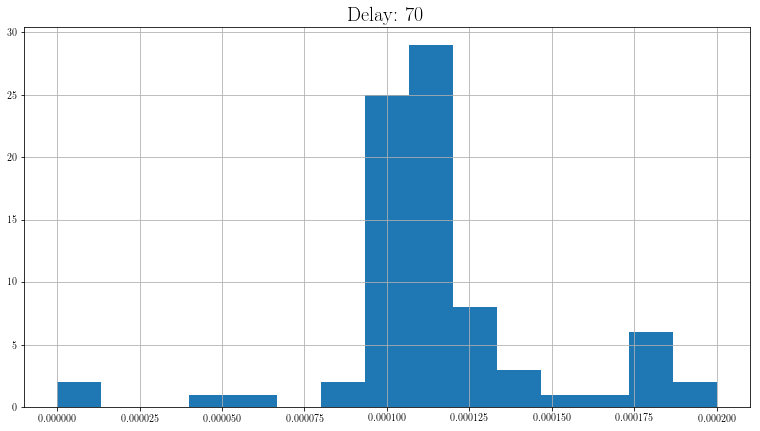

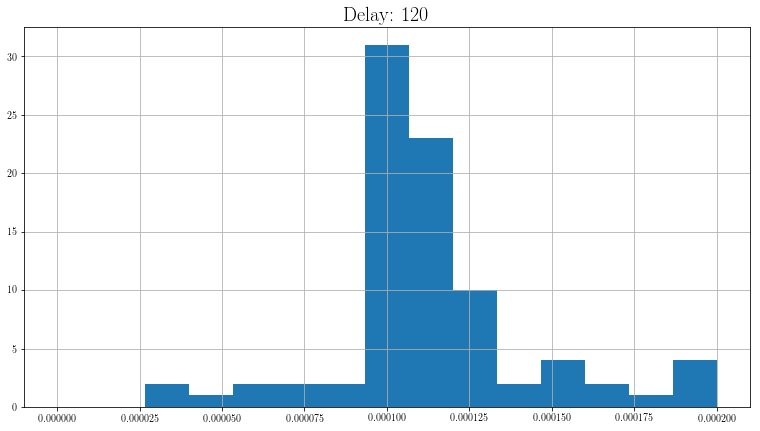

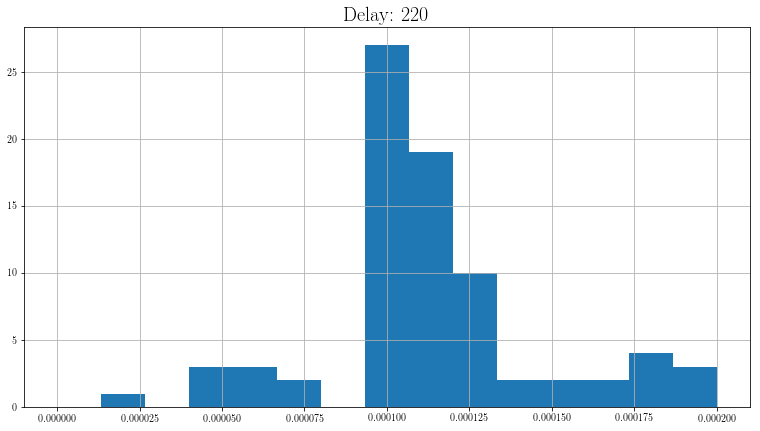

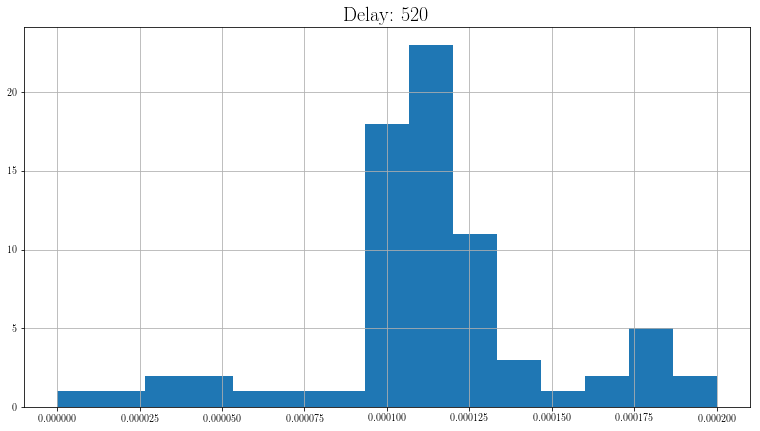

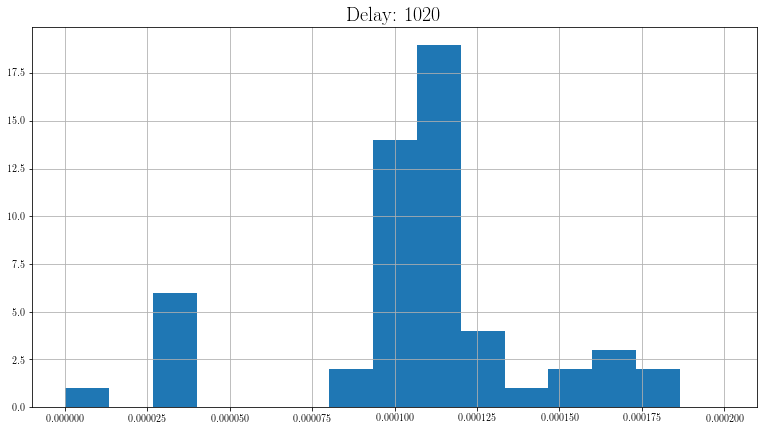

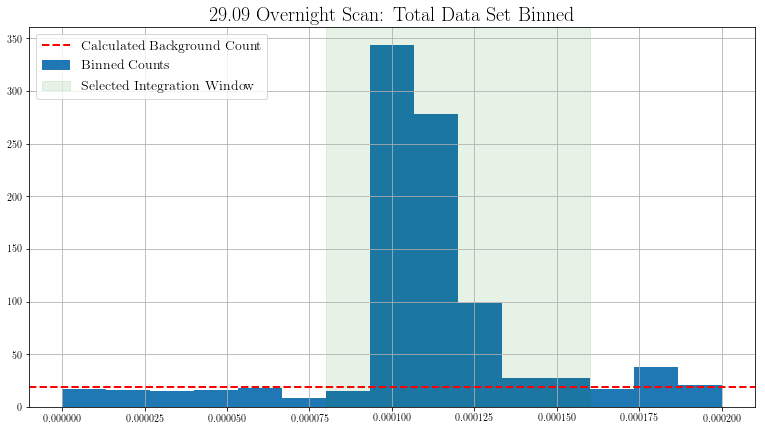

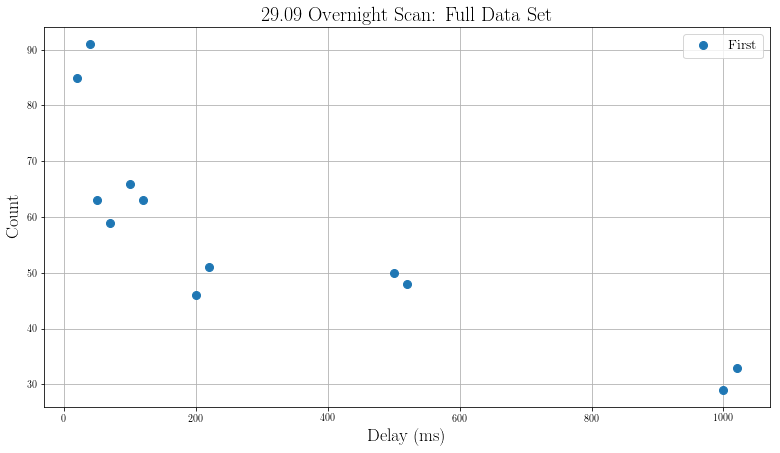

In [5]:
delaytotal, counttotal, = ProcessData(data, index, '29.09 Overnight Scan', DisplayFullOutput=True)